In [1]:
import NN_training
import MC_Sim
import Load_data
import Generate_plot as GP
import Trading
import Math_tools

import numpy as np
import torch
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from scipy.stats import skew

#Get real stock price
Time_step_True = Load_data.Load_time_and_date(FlieLocation="Stock_Data/NVDA/Historical_data/new_data/price.csv")
NVDA_True = Load_data.Load_mutiple_data(FlieLocation="Stock_Data/NVDA/Historical_data/new_data/price.csv",ExtractLabels=["Open","Close"])
NVDA_True_Open = np.array(NVDA_True[0][0][0])
NVDA_True_Close = np.array(NVDA_True[0][1][0])

In [2]:
# load models
MAG_model = NN_training.Load_model("NVDA","Moving_average_Gaussian/30_days")

OC_model = NN_training.Load_model("NVDA","Open_Close_Comparasion/OC")

MAV_model = NN_training.Load_model("NVDA","Moving_average_volatility_order/VO1_30_days")

Using model: Moving_average_Gaussian/30_days
Using model: Open_Close_Comparasion/OC
Using model: Moving_average_volatility_order/VO1_30_days


The first data point is 2023-07-05
Analysis start at 2023-07-06 to 2024-07-03


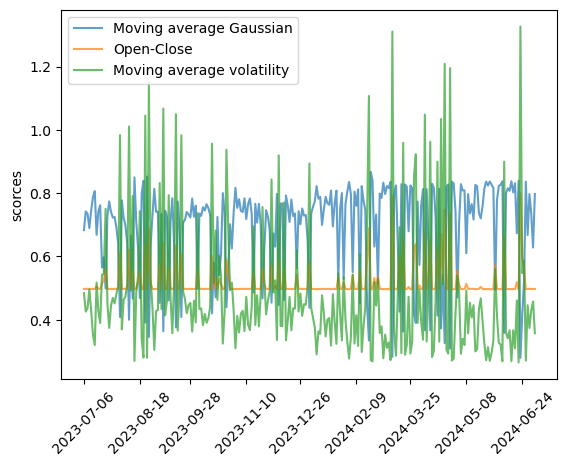

In [3]:
#NN on real data

True_open_yestaday = torch.tensor(NVDA_True_Open[:-1]).view(-1, 1).float()
True_close_yestaday = torch.tensor(NVDA_True_Close[:-1]).view(-1, 1).float()
True_open_today = torch.tensor(NVDA_True_Open[1:]).view(-1, 1).float()
True_data = torch.cat((True_open_yestaday, True_close_yestaday, True_open_today), dim=1)

MAG_scorces = NN_training.Generate_scorce(MAG_model,True_data).view(-1).detach().numpy()
OC_scorces = NN_training.Generate_scorce(OC_model,True_data).view(-1).detach().numpy()
MAV_scorces = NN_training.Generate_scorce(MAV_model,True_data).view(-1).detach().numpy()
Time_step_analysiable = Time_step_True[1:]
print("The first data point is", Time_step_True[0])
print("Analysis start at", Time_step_analysiable[0] ,'to', Time_step_analysiable[-1])
plt.plot(Time_step_True[1:],MAG_scorces,alpha=0.7,label = "Moving average Gaussian")
plt.plot(Time_step_True[1:],OC_scorces,alpha=0.7,label = "Open-Close")
plt.plot(Time_step_True[1:],MAV_scorces,alpha=0.7,label = "Moving average volatility")
plt.ylabel("scorces")
plt.legend()
ax2 = plt.gca()
ax2.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

In [4]:
## Real life trading

Principle = 2000 #in USD

True_price_End_date = datetime.date(2024,7,3)
True_price_start_date = True_price_End_date - datetime.timedelta(days=30)
 
print("Testing on data from ", True_price_start_date, "to", True_price_End_date)
Time_step_True_restricted, NVDA_True_Open_restricted = MC_Sim.Slice_time_series(NVDA_True_Open,Time_step_True,True_price_start_date,True_price_End_date)

Time_step_analysiable_resticted, MAG_score_restricted = MC_Sim.Slice_time_series(MAG_scorces,Time_step_analysiable,True_price_start_date,True_price_End_date)

_, OC_score_restricted = MC_Sim.Slice_time_series(OC_scorces,Time_step_analysiable,True_price_start_date,True_price_End_date)

_, MAV_score_restricted = MC_Sim.Slice_time_series(MAV_scorces,Time_step_analysiable,True_price_start_date,True_price_End_date)
print("-------------------------------------------------------------------------")
########################################################################################################################

#Optimizing the parameter using past X days data
Opt_End_date = True_price_start_date - datetime.timedelta(days=3)
Opt_start_date = Opt_End_date - datetime.timedelta(days=100)

print("Optimizing parameters using data from ", Opt_start_date, "to", Opt_End_date)

#Betting strategy

#betting_fraction = Trading.Get_Non_Binary_Kelly_f(NVDA_True_Open,Time_step_True,Opt_End_date,8)/2
betting_fraction = 1
print("Betting fraction = ", betting_fraction)

MAG_Call_scorce_opt, MAG_Short_scorce_opt = Trading.optimize_parameters_within_timeframe(Principle,Time_step_True, NVDA_True_Open, MAG_scorces, betting_fraction, Opt_start_date,Opt_End_date)
OC_Call_scorce_opt, OC_Short_scorce_opt = Trading.optimize_parameters_within_timeframe(Principle,Time_step_True, NVDA_True_Open, OC_scorces, betting_fraction, Opt_start_date,Opt_End_date)
MAV_Call_scorce_opt, MAV_Short_scorce_opt = Trading.optimize_parameters_within_timeframe(Principle,Time_step_True, NVDA_True_Open, MAV_scorces, betting_fraction, Opt_start_date,Opt_End_date)


print("Optimization finished")
print("Using the optimal call and short scorce for:")
print("Moving average Gaussian :", MAG_Call_scorce_opt, MAG_Short_scorce_opt)
print("Open-Close :", OC_Call_scorce_opt, OC_Short_scorce_opt)
print("Moving average volatility :", MAV_Call_scorce_opt, MAV_Short_scorce_opt)
print("-------------------------------------------------------------------------")

Testing on data from  2024-06-03 to 2024-07-03
-------------------------------------------------------------------------
Optimizing parameters using data from  2024-02-21 to 2024-05-31
Betting fraction =  1
Optimization finished
Using the optimal call and short scorce for:
Moving average Gaussian : 0.0 0.0
Open-Close : 0.0 0.0
Moving average volatility : 0.27 0.27
-------------------------------------------------------------------------


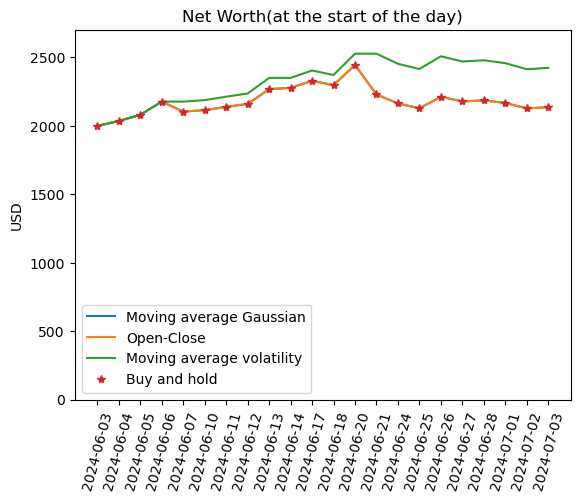

In [5]:
###################################################################################################################################################

MAG_share, MAG_cash, MAG_share_worth_record, MAG_cash_worth_record, MAG_N_C, MAG_N_S, MAG_N_N = Trading.Trade(Principle,NVDA_True_Open_restricted, MAG_score_restricted, betting_fraction, MAG_Call_scorce_opt, MAG_Short_scorce_opt)
MAG_Total_worth = MAG_share_worth_record + MAG_cash_worth_record

OC_share, MAG_cash, OC_share_worth_record, OC_cash_worth_record, OC_N_C, OC_N_S, OC_N_N = Trading.Trade(Principle,NVDA_True_Open_restricted, OC_score_restricted, betting_fraction, OC_Call_scorce_opt, OC_Short_scorce_opt)
OC_Total_worth = OC_share_worth_record + OC_cash_worth_record

MAV_share, MAV_cash, MAV_share_worth_record, MAV_cash_worth_record, MAV_N_C, MAV_N_S, MAV_N_N = Trading.Trade(Principle,NVDA_True_Open_restricted, MAV_score_restricted, betting_fraction, MAV_Call_scorce_opt, MAV_Short_scorce_opt)
MAV_Total_worth = MAV_share_worth_record + MAV_cash_worth_record

# Control:
Control_share, Control_stock_worth_record, Control_cash_record = Trading.Buy_and_hold(Principle,NVDA_True_Open_restricted)
Control_Total_worth = Control_stock_worth_record + Control_cash_record


#plt.plot(Time_step_analysiable_resticted, MAG_share_worth_record, label="Share worth")
#plt.plot(Time_step_analysiable_resticted, MAG_cash_worth_record, label="cash worth")

plt.plot(Time_step_analysiable_resticted, MAG_Total_worth, label="Moving average Gaussian")
plt.plot(Time_step_analysiable_resticted, OC_Total_worth, label="Open-Close")
plt.plot(Time_step_analysiable_resticted, MAV_Total_worth, label="Moving average volatility")
plt.plot(Time_step_analysiable_resticted,Control_Total_worth, "*", label="Buy and hold")
plt.ylabel("USD")
plt.ylim(0,2700)
plt.title("Net Worth(at the start of the day)")
plt.legend()
ax4 = plt.gca()
#ax4.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=75)
plt.show()

In [6]:
print("Net worth(Open) on ", True_price_End_date, ":")
print("------------------------------------------------------------------------------------------------------------------------------------------")
#print(MAG_share, "share of stock at ", NVDA_True_Open[-1])
#print(MAG_cash, "USD in cash")
print("NN: Moving average Gaussian:")
print("Net worth(Open) =", MAG_Total_worth[-1], "USD", ";Delta =", MAG_Total_worth[-1] - Principle, "USD", ";Groth =", (MAG_Total_worth[-1] - Principle)/Principle*100, "%")
print("Number: Call =", MAG_N_C, ";Short =", MAG_N_S, ";no action =", MAG_N_N)
print("------------------------------------------------------------------------------------------------------------------------------------------")
print("NN: Open-Close:")
print("Net worth(Open) =", OC_Total_worth[-1], "USD", ";Delta =", OC_Total_worth[-1] - Principle, "USD", ";Groth =", (OC_Total_worth[-1] - Principle)/Principle*100, "%")
print("Number: Call =", OC_N_C, ";Short =", OC_N_S, ";no action =", OC_N_N)
print("------------------------------------------------------------------------------------------------------------------------------------------")
print("NN: Moving average volatility:")
print("Net worth(Open) =", MAV_Total_worth[-1], "USD", ";Delta =", MAV_Total_worth[-1] - Principle, "USD", ";Groth =", (MAV_Total_worth[-1] - Principle)/Principle*100, "%")
print("Number: Call =", MAV_N_C, ";Short =", MAV_N_S, ";no action =", MAV_N_N)
print("------------------------------------------------------------------------------------------------------------------------------------------")
print("Control: buy and hold")
print("Net worth(Open) = ", Control_Total_worth[-1], "USD")
print("Net worth(Open) =", Control_Total_worth[-1], "USD", ";Delta =", Control_Total_worth[-1] - Principle, "USD", ";Groth =", (Control_Total_worth[-1] - Principle)/Principle*100, "%")
print("------------------------------------------------------------------------------------------------------------------------------------------")

Net worth(Open) on  2024-07-03 :
------------------------------------------------------------------------------------------------------------------------------------------
NN: Moving average Gaussian:
Net worth(Open) = 2136.663034 USD ;Delta = 136.66303400000015 USD ;Groth = 6.833151700000008 %
Number: Call = 22 ;Short = 0 ;no action = 0
------------------------------------------------------------------------------------------------------------------------------------------
NN: Open-Close:
Net worth(Open) = 2136.663034 USD ;Delta = 136.66303400000015 USD ;Groth = 6.833151700000008 %
Number: Call = 22 ;Short = 0 ;no action = 0
------------------------------------------------------------------------------------------------------------------------------------------
NN: Moving average volatility:
Net worth(Open) = 2423.798898 USD ;Delta = 423.798898 USD ;Groth = 21.1899449 %
Number: Call = 19 ;Short = 3 ;no action = 0
------------------------------------------------------------------------

In [7]:
#alpha/beta-analysis
print("alpha(over the market) beta(market dependency) analysis:")
print("----------------------------------------------------------------------------------")
MAG_alpha,MAG_beta =  Math_tools.Alpha_Beta(MAG_Total_worth,Control_Total_worth)
print("NN: Moving average Gaussian:")
print("(alpha, beta) = ",(MAG_alpha,MAG_beta))
print("----------------------------------------------------------------------------------")
OC_alpha,OC_beta =  Math_tools.Alpha_Beta(OC_Total_worth,Control_Total_worth)
print("NN: Open-Close:")
print("(alpha, beta) = ",(OC_alpha,OC_beta))
print("----------------------------------------------------------------------------------")
MAV_alpha,MAV_beta =  Math_tools.Alpha_Beta(MAV_Total_worth,Control_Total_worth)
print("NN: Moving average volatility:")
print("(alpha, beta) = ",(MAV_alpha,MAV_beta))
print("----------------------------------------------------------------------------------")

alpha(over the market) beta(market dependency) analysis:
----------------------------------------------------------------------------------
NN: Moving average Gaussian:
(alpha, beta) =  (-0.0, 1.0)
----------------------------------------------------------------------------------
NN: Open-Close:
(alpha, beta) =  (-0.0, 1.0)
----------------------------------------------------------------------------------
NN: Moving average volatility:
(alpha, beta) =  (1240.08, 0.403)
----------------------------------------------------------------------------------
